# Session 6: More on working with text data in scikit-learn

In the previous session, we used UMAP to visualize text data. In this lesson, we will learn how to use scikit-learn to prepare text data for machine learning, and then apply any ML model to solve a text classification task.

## Applications of text classification

Many business problems can be framed as text classification problems, specially those involving customer or user feedback.
The commond ground is that for all these applications, the input is just raw text (in a language such as English), so it can be challenging to apply machine learning to solve these problems.

Here are two examples.


### Sentiment Analysis 😍/😡

- Sentiment Analysis, also known as opinion mining, is a subfield of Natural Language Processing (NLP) that involves the use of machine learning, statistics, and natural language understanding to identify, extract and study affective states and subjective information from source materials. Typically, it is a supervised task.

- It's usually applied to text data to help **businesses monitor brand and product sentiment in customer feedback**, and understand customer needs.

- Sentiment analysis can be broadly categorized into document level, sentence level, and aspect level analysis. It can detect subjective information such as opinions, beliefs, evaluations, appraisals, and emotions.

- The challenges faced in sentiment analysis include **understanding the context, detecting sarcasm, and handling ambiguous sentences** that could have multiple meanings. 


![sentiment](images/sentimentanalysishotelgeneric-2048x803-1.jpg)



### Topic Classification 🔀

- Topic classification is the task of assigning a predefined category to an unlabeled text document.

- It is a supervised machine learning task where the training data is composed of documents that are already labeled with one or more categories.

- Topic classification is used in a variety of applications such as **spam filtering, email routing, and content-based recommendation**.

- The challenges faced in topic classification include handling noisy data, and dealing with the large number of categories that are often present in real-world applications, which leads to **imbalanced datasets**.

![topic](images/topic.png)

## Working with text data in ML

![flow](images/flow.png)


### Feature processing

- Feature processing is the process of transforming text into a more digestible form so that it can be easily consumed by machine learning algorithms. There are usually two phases in text processing: tokenization and vectorization.
    
1. **Tokenization**: the process of splitting a text into smaller units called tokens. It is the first step in text processing. The tokens could be words, sentences, or even characters. The tokens are then used as the basic building blocks for any NLP task.
    
2. **Vectorization**: the process of converting text into numerical representations called vectors. It is the second step in text processing. The vectors are then used as input to machine learning algorithms.

In scikit-learn, the `CountVectorizer` and `TfidfVectorizer` classes are used for both tokenization and vectorization.

* **CountVectorizer**: converts a collection of text documents to a matrix of token counts, following the bag-of-words approach. 

* **TfidfVectorizer**: converts a collection of raw documents to a matrix of TF-IDF features (more on this later).


## Example task: complaint classification 🤬

In this lesson, we will use a subset of the [Consumer Complaint Database](https://www.consumerfinance.gov/data-research/consumer-complaints/) from the Consumer Financial Protection Bureau (CFPB) to build a text classification model that can automatically classify consumer complaints into several categories.

With a good model, the application can automatically classify complaints into categories, and route them to the appropriate department for further processing.

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('complaints.csv')

In [3]:
# pandas show full text
pd.set_option('display.max_colwidth', 1)

df.sample(5)

,Product,Consumer_complaint_narrative,category_id
3167,Debt collection,I have requested debt verification of this debt and have yet to receive it.,0
2505,Student loan,"I enrolled in Auto-Pay with Mohela before the federal pause on student loan repayments was lifted, but the auto-pay didn't work. Myself and thousands of others are now "" delinquent '' on our first payment because Mohela failed to notify borrowers that the auto-pay wouldn't work until 2-3 billing cycles. Unsure if this will have an impact on credit reporting because its takes 5+ hours to speak to a representative.",1
2039,Debt collection,"I contacted XXXX prior to XXXX XXXX, XXXX to inform them that I was moving to a new residence. XXXX informed me that they did/could not provide service at my new address ( which happened to be in a different state ) and therefore I needed to stop my service. They did not inform me that I owed anything, but that I needed to return my devices that were owed to them. \nOn XXXX XXXX, XXXX I received an email ( the only email after stopping service, email is attached ) stating that they had received my disconnect request, and again, did not state I owed any money. \nOn XXXX XXXX, XXXX I returned the devices to the XXXX store in person, was told that I did not owe anything, and received a receipt stating that the devices had been returned ( attached ). \nOn XXXX XXXX, XXXX I received a letter from a collection agency Diversified Consultants Inc. ( letter attached, letter dated XXXX XXXX, XXXX ) stating I owed a debt of {$220.00} to XXXX. I contacted XXXX and they informed me I owed the money as a cancellation fee as I had voluntarily cancelled my service. I informed them that I did not have an option, I did not want to cancel the service, but that XXXX could not provide service in the new residence I was moving to and therefore should not be liable for this cancellation fee, and in addition, XXXX never contacted me informing me I would owe this fee if I cancelled service. XXXX agent informed me that there was nothing they could do, but would have a supervisor call me back to resolve the issue. No supervisor ever called me. \nOn XXXX XXXX, XXXX I sent a letter to Diversified Consultants Inc. disputing the debt ( attached ). \nOn XXXX XXXX, XXXX I received a letter from Diversified Consultants Inc. stating that the amount I owed was valid. Also with that letter was a bill from XXXX ( attached ) stating that my service was disconnected with a balance due of {$220.00}.\n\nI am disputing these charges because : 1 ) I was never informed prior, during, or after disconnecting my service from XXXX that I would be billed a disconnection fee. XXXX never contacted me about the fee before turning it over to a collection agency. \n2 ) I had no other option but to disconnect service from XXXX because they could not provide service at my new residence and I should not be responsible for this fee. \n3 ) I paid all money owed to XXXX for services delivered over a 4 year period, and should not be unduly charged a fee for moving to a new location, which this debt will negatively impact my otherwise good credit.",0
1540,Bank account or service,"I tried opening a checking account with HSBC on XXXX XXXX 2016. Followed all the instructions and initiated opening balance of {$1500.00} to be deposited into that against my application id. Payment also went thru. After that i just keep on getting emails from HSBC - somebody sitting in XXXX asking me to send the driver 's license, utility bills etc ... all done within the next 3 days. So around XXXX XXXX 2016 - all the formalities were done. I just have my application id and nothing else from them. HSBC expect the customers to know about their secure messaging system to communicate with them which is quite a task also. \nNow after the wait of more than 2 weeks ( when i did n't got any email or communication in terms of what happened to my account and the deposit ) -i called them up. They asked me to call to their

Let's have a look at the classes distribution

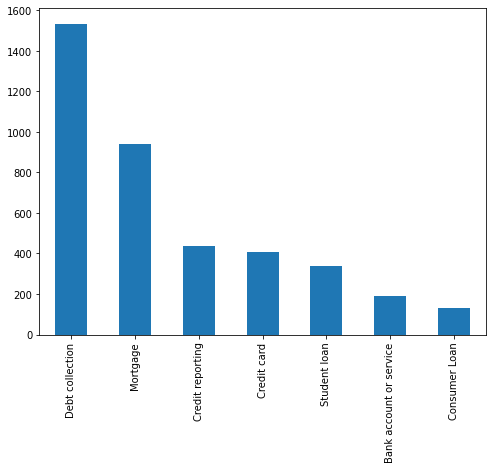

In [4]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.Product.value_counts().plot.bar(ylim=0)
plt.show()

Seems that the dataset is imbalanced, which is a common problem in text classification tasks.

As usual, the next step is to split the data into training and test sets. Notice here we just have one column for the X, and another for the classes.

> ⚠️ Since the data is imbalanced, when doing the splitting it is best to use the stratify option, so that the classes distribution is preserved in the training and test sets:
>
> ![image](images/strata.png)


In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

X = df.Consumer_complaint_narrative
y = df.Product

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0, test_size=0.5, stratify=y)

We only have the raw texts as the only feature, let's do some **feature processing**.

We will use first sklearn's CountVectorizer class to do this for us along with a couple other preprocessing steps:

1. Split the text into tokens (i.e. words) by splitting on whitespace.
2. Remove english stopwords (the, and, etc), to remove noise from the data.
3. Remove all infrequent words (which occur less than 5 times) in the entire corpus (via the min_df parameter).

Reference: https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction


One the CountVectorizer has applied the previous set of steps, then it just counts the number of times each word appears in each document, and returns a **matrix of counts**. This is what is call a **bag-of-words** representation. This resulting matrix is also called an **embeding matrix**

![bow](images/bag-of-words.png)

In [6]:
from sklearn.feature_extraction.text import CountVectorizer

feature_processor = CountVectorizer(stop_words='english', min_df=5)

In [7]:
feature_processor.fit(X_train)  # gets the vocabulary
embed_train = feature_processor.transform(X_train)  # computes the counts for the vocabulary

In [8]:
embed_train = feature_processor.fit_transform(X_train)
embed_test = feature_processor.transform(X_test)

Let's check the dimensions of the embedding matrix:

In [9]:
embed_train.shape

(1989, 2992)

* We have 1989 documents (rows) in the training set.
* After the tokenization, we only have 2992 unique words (columns) in the vocabulary.

After the feature processing, we have a numeric matrix, so we can apply any supervised ML model to solve the classification task.

In [10]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=10, n_jobs=2, random_state=0)

rfc.fit(embed_train, y_train)

RandomForestClassifier(n_estimators=10, n_jobs=2, random_state=0)

### Since the data is imbalanced, instead of the accuracy, we just focus on the precision, recall and F1-score metrics.

![metrics](images/metrics.png)

As we have more than two classes, we compute each metric for each class (against the others), and then compute the average across all classes.

This can be easily done using the `classification_report` function from sklearn.

In [11]:
# classification report
from sklearn.metrics import classification_report

y_pred = rfc.predict(embed_test)

print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

Bank account or service       0.69      0.39      0.49        96
          Consumer Loan       0.40      0.03      0.06        65
            Credit card       0.62      0.64      0.63       205
       Credit reporting       0.59      0.48      0.53       219
        Debt collection       0.72      0.88      0.79       766
               Mortgage       0.80      0.86      0.83       469
           Student loan       0.86      0.50      0.63       169

               accuracy                           0.72      1989
              macro avg       0.67      0.54      0.57      1989
           weighted avg       0.71      0.72      0.70      1989



We have an averaged F1-score of 0.70, which is not bad for a first model. Let's see if we can improve it.

### TF-IDF Vectorizer


The TF-IDF vectorizer is another way to vectorize text data. It is similar to the CountVectorizer, but it also takes into account the frequency of each word in the entire corpus, and not just in each document.

Each position in the embedding matrix is computed with the following formula:

For a word $i$ in document (sample) $j$, the TF-IDF score is computed as follows:


$$
w_{i, j} = tf_{i, j} \times log \left( \frac{N}{df_i} \right)
$$

where

* $tf_{i, j}$ is the number of times word $i$ appears in document $j$ (same as the CountVectorizer). Sometimes this is an average instead of a sum.
* $df_i$ is the number of documents that contain word $i$.
* $N$ is the total number of documents.


The last term (the log of the inverse) adjusts for the fact that some words appear more frequently in general, so they should have less weight.


### Example calculation

![example](images/example.png)

### In scikit-learn, the TfidfVectorizer class does all this for us.

It also includes the tokenization and filering steps, similarly to CountVectorizer.

In [12]:
tfidf = TfidfVectorizer(min_df=5, stop_words='english')

In [13]:
embed_train = tfidf.fit_transform(X_train)
embed_test = tfidf.transform(X_test)

Notice that the vocabulary is the same:

(only the values of the matrix change, based on the previous formula)

In [14]:
embed_train.shape

(1989, 2992)

In [15]:
rfc = RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=0)

rfc.fit(embed_train, y_train)

y_pred = rfc.predict(embed_test)

print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

Bank account or service       0.73      0.45      0.55        96
          Consumer Loan       0.33      0.03      0.06        65
            Credit card       0.67      0.62      0.65       205
       Credit reporting       0.68      0.43      0.53       219
        Debt collection       0.71      0.90      0.79       766
               Mortgage       0.80      0.89      0.84       469
           Student loan       0.90      0.58      0.71       169

               accuracy                           0.74      1989
              macro avg       0.69      0.56      0.59      1989
           weighted avg       0.73      0.74      0.72      1989



Now the F1-score is 0.72, which is a slight improvement over the previous model!

### When to choose CountVectorizer vs TfidfVectorizer?

This is a common question, and the answer is: it depends on the dataset. You should try both and see which one works best for your dataset, as if it were an hyperparameter.

## Writing less code: Pipelines

In the previous examples, we had to write a lot of code to do the feature processing, and then apply the ML model.

In scikit-learn, we can use **pipelines** to simplify this process.

A pipeline is a sequence of steps that are executed in order, and the output of each step is used as the input to the next step.

In [16]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('vect', TfidfVectorizer(min_df=5, stop_words='english')),
    ('clf', RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=0))
])

In [17]:
pipeline

Pipeline(steps=[('vect', TfidfVectorizer(min_df=5, stop_words='english')),
                ('clf',
                 RandomForestClassifier(n_estimators=10, n_jobs=-1,
                                        random_state=0))])

Instead of several .fit, we can just call .fit on the pipeline, and it will do all the steps for us.

In [18]:
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

Bank account or service       0.73      0.45      0.55        96
          Consumer Loan       0.33      0.03      0.06        65
            Credit card       0.67      0.62      0.65       205
       Credit reporting       0.68      0.43      0.53       219
        Debt collection       0.71      0.90      0.79       766
               Mortgage       0.80      0.89      0.84       469
           Student loan       0.90      0.58      0.71       169

               accuracy                           0.74      1989
              macro avg       0.69      0.56      0.59      1989
           weighted avg       0.73      0.74      0.72      1989



We can make the pipeline as complex as we want, and it will still work ⚗️

For example, let's add a dimensionality reduction step to the pipeline, using PCA or UMAP.

In [19]:
import sklearn

sklearn.__version__

'1.4.0'

In [20]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

pipeline = Pipeline([
    ('vect', TfidfVectorizer(min_df=5, stop_words='english')),
    ('pca', PCA(n_components=50, svd_solver="arpack")),
    ('clf', RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=0))
])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

Bank account or service       0.68      0.62      0.65        96
          Consumer Loan       0.17      0.03      0.05        65
            Credit card       0.63      0.60      0.61       205
       Credit reporting       0.69      0.57      0.62       219
        Debt collection       0.73      0.88      0.80       766
               Mortgage       0.81      0.82      0.82       469
           Student loan       0.86      0.60      0.71       169

               accuracy                           0.74      1989
              macro avg       0.65      0.59      0.61      1989
           weighted avg       0.72      0.74      0.73      1989



In [21]:
pipeline

Pipeline(steps=[('vect', TfidfVectorizer(min_df=5, stop_words='english')),
                ('pca', PCA(n_components=50, svd_solver='arpack')),
                ('clf',
                 RandomForestClassifier(n_estimators=10, n_jobs=-1,
                                        random_state=0))])

## Exercise: Sentiment Analysis on Movie Reviews 🎥

In [22]:
from sklearn.datasets import load_files

movie_reviews_data_folder = 'data/movie_reviews'

dataset = load_files(movie_reviews_data_folder, shuffle=False)

We have around 2000 movie reviews, and we want to classify them as positive or negative.

In [23]:
len(dataset.data)

2000

In [24]:
dataset.target_names

['neg', 'pos']

In [25]:
X = dataset.data
y = dataset.target

Let's have a look at some of the reviews:

In [26]:
print(X[2])

b"it is movies like these that make a jaded movie viewer thankful for the invention of the timex indiglo watch . \nbased on the late 1960's television show by the same name , the mod squad tells the tale of three reformed criminals under the employ of the police to go undercover . \nhowever , things go wrong as evidence gets stolen and they are immediately under suspicion . \nof course , the ads make it seem like so much more . \nquick cuts , cool music , claire dane's nice hair and cute outfits , car chases , stuff blowing up , and the like . \nsounds like a cool movie , does it not ? \nafter the first fifteen minutes , it quickly becomes apparent that it is not . \nthe mod squad is certainly a slick looking production , complete with nice hair and costumes , but that simply isn't enough . \nthe film is best described as a cross between an hour-long cop show and a music video , both stretched out into the span of an hour and a half . \nand with it comes every single clich ? . \nit doe

0 is the negative class

In [27]:
print(y[2])

0


In [28]:
y[-1]

1

In [29]:
X[-1]

b'truman ( " true-man " ) burbank is the perfect name for jim carrey\'s character in this film . \npresident truman was an unassuming man who became known worldwide , in spite of ( or was it because of ) his stature . \n " truman " also recalls an era of plenty following a grim war , an era when planned communities built by government scientists promised an idyllic life for americans . \nand burbank , california , brings to mind the tonight show and the home of nbc . \nif hollywood is the center of the film world , burbank is , or was , the center of tv\'s world , the world where our protagonist lives . \ncombine all these names and concepts into " truman burbank , " and you get something that well describes him and his artificial world . \ntruman leads the perfect life . \nhis town , his car , and his wife are picture perfect . \nhis idea of reality comes under attack one day when a studio light falls from the sky . \nthe radio explains that an overflying airplane started coming apart

Let's use a Logistic Regression model to classify the reviews, for the moment, with the CountVectorizer.

In [30]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([
    ("vectorizer", CountVectorizer(stop_words="english", min_df=5)),
    ("model", LogisticRegression(max_iter=10000))
])

pipe

Pipeline(steps=[('vectorizer', CountVectorizer(min_df=5, stop_words='english')),
                ('model', LogisticRegression(max_iter=10000))])

In [31]:
import numpy as np
np.mean(y)

0.5

In [32]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5, random_state=30, stratify=y)


In [33]:
pipe.fit(X_train, y_train)



Pipeline(steps=[('vectorizer', CountVectorizer(min_df=5, stop_words='english')),
                ('model', LogisticRegression(max_iter=10000))])

In [34]:
y_pred = pipe.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.85      0.84       500
           1       0.85      0.81      0.83       500

    accuracy                           0.83      1000
   macro avg       0.83      0.83      0.83      1000
weighted avg       0.83      0.83      0.83      1000



**Question**: Which words are most associated with positive sentiment? And negative sentiment?


Hint: inspect the coefficients of the logistic regression model

In [35]:
coeffients = pipe[-1].coef_

coeffients.shape

(1, 8290)

In [36]:
idx_max_value = np.argmax(coeffients[0, :])
idx_max_value

3274

In [37]:
list_of_words = pipe[0].get_feature_names_out()
list_of_words

array(['00', '000', '007', ..., 'zoo', 'zoom', 'zooms'], dtype=object)

In [38]:
len(list_of_words)

8290

In [39]:
list_of_words[idx_max_value]

'great'

In [40]:
idx_min_value = np.argmin(coeffients[0, :])
idx_min_value

list_of_words[idx_min_value]

'bad'

In [41]:
for idx, word in enumerate(list_of_words):
    name = "sandler"
    if word == name:
        print(word, "at position ", idx)

sandler at position  6344


In [42]:
coeffients[0, 6344]

-0.1077936704240874

In [43]:
for idx, word in enumerate(list_of_words):
    name = "schwarzenegger"
    if word == name:
        print(word, "at position ", idx)

schwarzenegger at position  6407


In [44]:
coeffients[0, 6407]

0.025743839642149158

In [45]:
for idx, word in enumerate(list_of_words):
    name = "downey"
    if word == name:
        print(word, "at position ", idx)

downey at position  2232


In [46]:
coeffients[0, 2232]

0.033775598499130574

In [47]:
for idx, word in enumerate(list_of_words):
    name = "garfield"
    if word == name:
        print(word, "at position ", idx)

In [48]:
coeffients[0, 1096]

-0.012578649441631909